In [89]:
import cv2
import pytesseract
from pytesseract import Output
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from ocrutils.imageops import is_a_picture, prepare_image

Carregando imagem

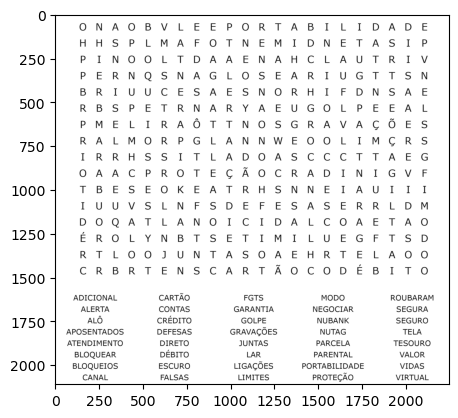

In [90]:
path_data = Path.cwd().joinpath('data','wordsearch.png')
img = cv2.imread(str(path_data.resolve()))
plt.imshow(img)

config tesseract

In [ ]:
tessdata_dir = Path.cwd().joinpath('tessdata')
whitelist = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789áàâãéêíóôõúüçÁÀÂÃÉÊÍÓÔÕÚÜÇ"
blacklist = " "
config_img = f'--psm 11 --tessdata-dir {tessdata_dir} -c tessedit_char_whitelist={whitelist} -c tessedit_char_blacklist={blacklist}'
config_wordsearch= f'--psm 6 --tessdata-dir {tessdata_dir} -c tessedit_char_whitelist={whitelist} -c tessedit_char_blacklist={blacklist}'

Gray + threshold

In [92]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

Reconhecimento das regiões

In [ ]:
if (not is_a_picture(img)):
    img_data = pytesseract.image_to_data(img, config=config_img, lang ='por', output_type=Output.DICT)
else:
    img = prepare_image(img)
    img_data = pytesseract.image_to_data(img, config=config_img, lang ='por', output_type=Output.DICT)

In [94]:
def detect_words_area(data: dict, img) -> tuple:
    img_h, img_w = img.shape[:2]  
    chaves = list(data.keys())
    size = len(data[chaves[0]])
    left_min, top_min, bottom_max, right_max = img_w, img_h, 0, 0
    #left_min = posicao mais a esquerda possivel
    #top_min = posicao mais alto possivel

    for i in range(size):
        if len(data['text'][i]) > 3:
            x = data['left'][i]
            y = data['top'][i]
            w = data['width'][i]
            h = data['height'][i]
            
            left_min = min(left_min, x)
            top_min = min(top_min, y)
            right_max = max(right_max, x + w)
            bottom_max = max(bottom_max, y + h)

    return left_min, top_min, right_max, bottom_max

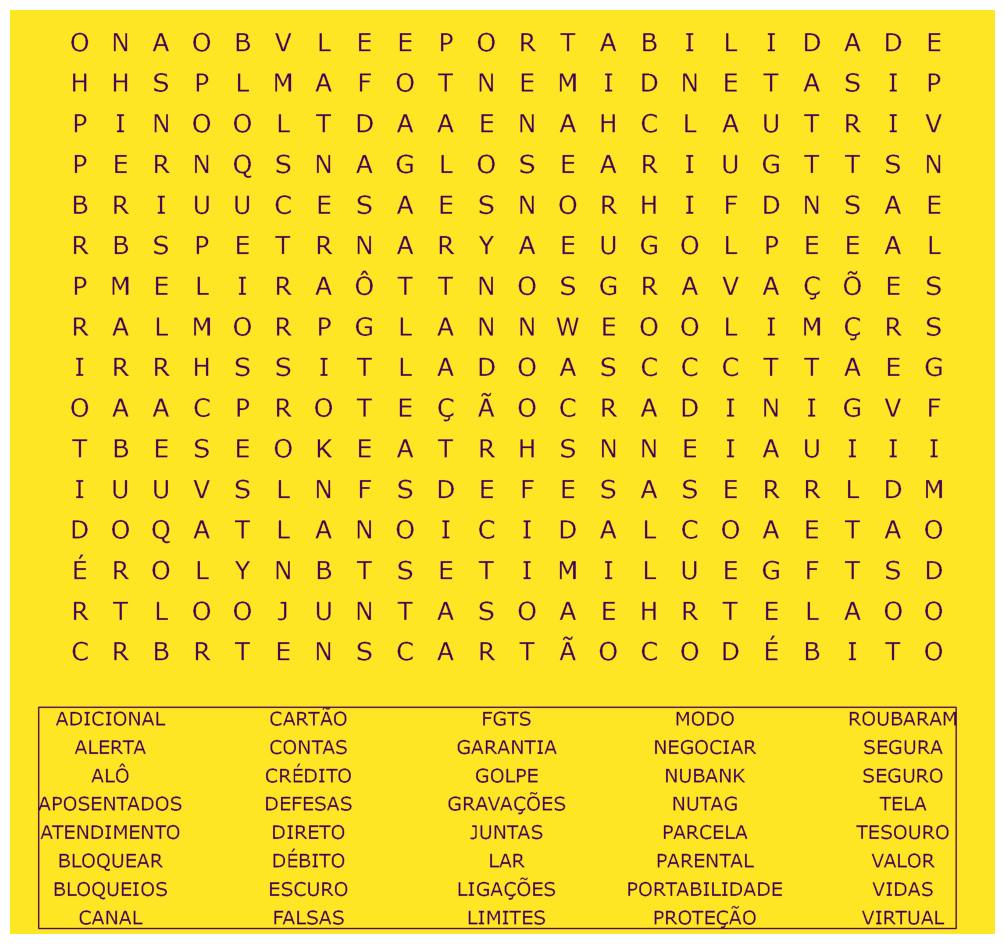

In [95]:
x1, y1, x2, y2 = detect_words_area(img_data, img)
img_copi = img.copy()
cv2.rectangle(img_copi, (x1, y1), (x2, y2), 0, 2)
plt.figure(figsize=(15, 12))
plt.imshow(img_copi)
plt.axis('off')
plt.show()   

['', '', '', '', 'ADICIONAL', 'CARTAO', 'FGTS', 'MODO', 'ROUBARAM', '', 'ALERTA', 'CONTAS', 'GARANTIA', 'NEGOCIAR', 'SEGURA', '', 'AL', 'CRDITO', 'GOLPE', 'NUBANK', 'SEGURO', '', 'APOSENTADOS', 'DEFESAS', 'GRAVAES', 'NUTAG', 'TELA', '', 'ATENDIMENTO', 'DIRETO', 'JUNTAS', 'PARCELA', 'TESOURO', '', 'BLOQUEAR', 'DBITO', 'LAR', 'PARENTAL', 'VALOR', '', 'BLOQUEIOS', 'ESCURO', 'LIGAES', 'PORTABILIDADE', 'VIDAS', '', 'CANAL', 'FALSAS', 'LIMITES', 'PROTECO', 'VIRTUAL']


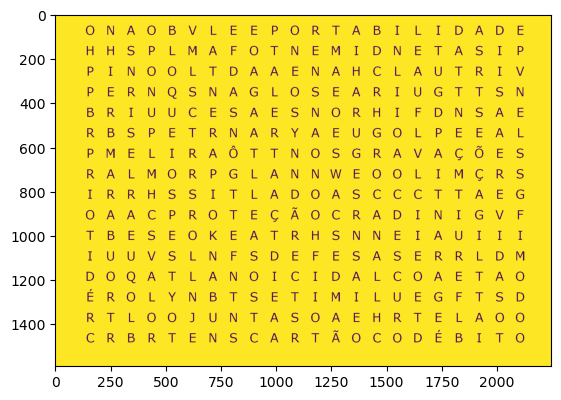

In [ ]:
x1, y1, x2, y2 = detect_words_area(img_data, img)
y, x = img.shape[:2]
img_zoom = img[0:y1, 0:x]
img_data = pytesseract.image_to_data(img_zoom, config=config_wordsearch, lang ='por', output_type=Output.DICT)

print(img_data['text'])

plt.imshow(img_zoom)

In [97]:
"""
def zoom_word_search(img, loc : tuple):
    #loc -> (x1,y1,x2,y2)
    img_h, img_w = img.shape[:2]  
    
def loc_word_area(img_shape, loc : tuple):
"""


'\ndef zoom_word_search(img, loc : tuple):\n    #loc -> (x1,y1,x2,y2)\n    img_h, img_w = img.shape[:2]  \n    \ndef loc_word_area(img_shape, loc : tuple):\n'